# TESTING KNN, AND ANN MODELS FOR THE RSA CLUSTER LABEL PREDICTION

### IMPORTING NECESSATY PACKAGES

In [1]:
from fragsys_analysis import *

In [2]:
from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

2023-05-01 15:49:30.508120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## SOME FUNCTIONS

In [3]:
def plot_loss(hist_df):
    n_epochs = len(hist_df)
    ax1 = sns.lineplot(x = list(range(n_epochs)), y = hist_df["loss"], c = "royalblue", label = "loss")
    sns.lineplot(x = list(range(n_epochs)), y = hist_df["val_loss"], c = "orange", ax = ax1, label = "val_loss")
    plt.axvline(x = 300, linestyle = "--", color = "red", linewidth = 1.5)

def plot_acc(hist_df):
    n_epochs = len(hist_df)
    ax2 = sns.lineplot(x = list(range(n_epochs)), y = hist_df["accuracy"], c = "royalblue", label = "accuracy")
    sns.lineplot(x = list(range(n_epochs)), y = hist_df["val_accuracy"], c = "orange", ax = ax2, label = "val_accuracy")
    ax2.legend()
    plt.axvline(x = 300, linestyle = "--", color = "red", linewidth = 1.5)
    
def get_confidences_df(preds, round_preds, vals):
    confs = []
    for row in preds:
        row = sorted(list(row), reverse = True)
        confidence = int(10*(row[0] - row[1]))
        confs.append(confidence)
        
    conf_df = pd.DataFrame(list(zip(confs, list(vals), list(round_preds))), columns = ["conf", "val", "pred"])
    
    un_confs = sorted(conf_df.conf.unique().tolist())
    covs = []
    accs = []
    for un_conf in un_confs:
        confi_df = conf_df[conf_df.conf >= un_conf]
        covs.append(len(confi_df)/len(conf_df))
        p_correct = len(confi_df[confi_df.val == confi_df.pred])/len(confi_df)
        accs.append(p_correct)
    
    conf_df_sum = pd.DataFrame(list(zip(un_confs, covs, accs)), columns = ["conf", "cov", "acc"])
    
    return conf_df, conf_df_sum

def plot_conf_acc_cov(conf_df_sum):
    # create figure and axis objects with subplots()
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    # make a plot
    ax.plot(conf_df_sum["conf"],
            conf_df_sum["cov"],
            color="firebrick", 
            marker="o",
           label = "Coverage", markeredgewidth = 1, markeredgecolor = "k")
    # set x-axis label
    ax.set_xlabel("Confidence score", fontsize = 14)
    # set y-axis label
    ax.set_ylabel("Coverage",
                  color="firebrick",
                  fontsize=14)
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(conf_df_sum["conf"], conf_df_sum["acc"],color="royalblue",marker="D", label = "Average accuracy", markeredgewidth = 1, markeredgecolor = "k")
    ax2.set_ylabel("Average accuracy",color="royalblue",fontsize=14)
    ax2.set_xlabel("Average confidence",color="royalblue",fontsize=14)
    #ax2.set_yticks(np.arange(0.85,1.05, 0.05))
    #ax2.set_ylim(0.845,1.005)
    plt.xticks(range(0,10))
    plt.show()

### READING INPUT DATA

In [5]:
main_dir = "."
results_dir = os.path.join(main_dir, "results")

rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict_NEW.pkl"))
cluster_membership = load_pickle(os.path.join(results_dir, "rsa_cluster_membership_NEW.pkl"))
rsa_profs = load_pickle(os.path.join(results_dir, "rsa_profs_NEW.pkl"))
ud_mat = pd.read_pickle(os.path.join(results_dir, "UD_df.pkl"))
vector_df = pd.read_pickle(os.path.join(results_dir, "rsa_vectors.pkl"))

In [6]:
vector_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10
Q9UGL1_0_BS0,0.675,0.481,0.296,0.074,0.074,0.000,0.074,0.0,0.0,0.0,0.0
Q9UGL1_0_BS1,0.300,0.417,0.083,0.167,0.083,0.083,0.167,0.0,0.0,0.0,0.0
Q9UGL1_0_BS2,0.250,0.300,0.100,0.200,0.200,0.200,0.000,0.0,0.0,0.0,0.0


In [7]:
vector_df.shape

(293, 11)

### CREATING LABEL DATAFRAME

In [8]:
label_df = pd.DataFrame.from_dict(rsa_cluster_dict, orient = "index", columns = ["label"])

In [9]:
round(label_df.label.value_counts().sort_index()/len(label_df),2)

0    0.16
1    0.43
2    0.31
3    0.10
Name: label, dtype: float64

In [10]:
label_df.shape

(293, 1)

In [11]:
X = vector_df.sort_index() # here, X is still a dataframe. Thus, we maintain binding site IDs
y = label_df.sort_index()    # here, y is still a list

### DATA SPLIT IN MODEL (10/11) (USED FOR TRAINING) AND BLIND (USED FOR FINAL TESTING) (1/11) STRATIFYING BY CLUSTER LABEL, SO THEY ARE BALANCED

In [12]:
X_model, X_blind, y_model, y_blind = train_test_split(X, y, test_size = 0.091, random_state = 12345, shuffle = True, stratify = y) ### X_blind and y_blind will be the blind test at the end

In [13]:
list(X.index) == list(y.index)

True

In [14]:
X_model_df, X_blind_df, y_model_df, y_blind_df = train_test_split(X, y, test_size = 0.091, random_state = 12345, shuffle = True, stratify = y) ### X_blind and y_blind will be the blind test at the end

In [15]:
print(X_model_df.shape)
print(X_blind_df.shape)
print(y_model_df.shape)
print(y_blind_df.shape)

(266, 11)
(27, 11)
(266, 1)
(27, 1)


In [16]:
round(y_model.label.value_counts().sort_index()/len(y_model),2)

0    0.16
1    0.43
2    0.31
3    0.10
Name: label, dtype: float64

In [17]:
round(y_blind.label.value_counts().sort_index()/len(y_blind),2)

0    0.15
1    0.44
2    0.30
3    0.11
Name: label, dtype: float64

## ANALYSIS OF DIFFERENT SEEDS AND BEST MODEL SELECTION

In [18]:
wd = "./results/ANN_results/diff_seeds"

In [19]:
seeds = os.listdir(wd)

In [20]:
print(seeds)

['61899', '85406', '58916', '74607', '15456', '99741', '8272', '17612', '64938', '33433']


In [21]:
best_acc_rows = []
weird_runs = []
for seed in seeds:

    seed_dir = os.path.join(wd, str(seed))
    hist_dir = os.path.join(seed_dir, "hists")
    hist_files = os.listdir(hist_dir)
    for hist in hist_files:
        
        hist_df = pd.read_csv(os.path.join(hist_dir, hist))
        data = hist.split("_")
        n = int(data[1])
        f_epoch = int(data[4])
        hist_df["seed"] = seed
        hist_df["n"] = n
        if f_epoch == -100:
            weird_runs.append(os.path.join(hist_dir, hist))
            f_epoch = 299

        acc = hist_df.loc[f_epoch,"val_accuracy"]
        best_acc_rows.append(hist_df.loc[f_epoch, :])

In [22]:
best_models = pd.DataFrame(best_acc_rows)
best_models["epoch"] = best_models.index
best_models.seed = best_models.seed.astype(int)
best_models.n = best_models.n.astype(int)
best_models.epoch = best_models.epoch.astype(int)
best_models = best_models.sort_values(["seed", "n"])
best_models.index = list(range(len(best_models)))

In [23]:
best_models.head(3)

,loss,accuracy,val_loss,val_accuracy,seed,n,epoch
0,0.260870,0.933962,0.344050,0.907407,8272,0,38
1,0.352722,0.877358,0.415730,0.925926,8272,1,29
2,0.247079,0.929245,0.333611,0.925926,8272,2,38


### COMPARISON BETWEEN DIFFERENT SEED MODELS

#### VALIDATION LOSS

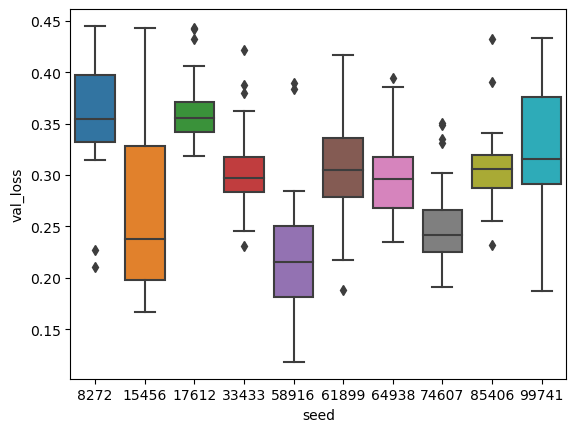

In [24]:
sns.boxplot(x = "seed", y = "val_loss", data = best_models)
plt.show()

#### VALIDATION ACCURACY

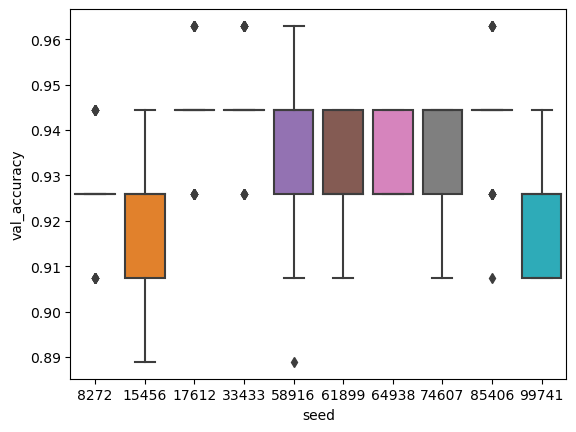

In [25]:
sns.boxplot(x = "seed", y = "val_accuracy", data = best_models)
plt.show()

#### ALL TRAINING METRICS ACROSS SEEDS (N = 500)

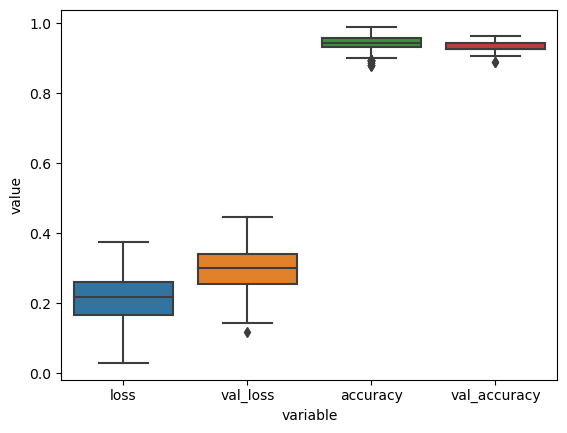

In [26]:
sns.boxplot(x = "variable", y = "value", data = pd.melt(best_models.loc[:,['loss', 'val_loss', 'accuracy', 'val_accuracy']]))
plt.show()

#### SELECTING BEST MODEL

In [27]:
best_models.query('val_accuracy > 0.95 & val_loss < 0.2').sort_values(by=["val_accuracy", "val_loss", "accuracy", "loss"])

,loss,accuracy,val_loss,val_accuracy,seed,n,epoch
221,0.029318,0.990566,0.118169,0.962963,58916,21,299
242,0.063970,0.981132,0.142527,0.962963,58916,42,156
237,0.061726,0.981132,0.148922,0.962963,58916,37,152
208,0.057356,0.981132,0.154149,0.962963,58916,8,174
241,0.063531,0.981132,0.162264,0.962963,58916,41,151
238,0.088149,0.971698,0.169707,0.962963,58916,38,112
217,0.031303,0.990566,0.175386,0.962963,58916,17,299


The best model chosen is the following: seed = 58916, n = 21, epoch = 299, val_accuracy = 0.96. This decision was made based on the models' validation accuracy, validation loss, and training accuracy, and loss in that order.

In [28]:
ff = pd.read_csv("./results/ANN_results/diff_seeds/58916/hists/58916_21_hist_epoch_-100_train_acc_0.91.csv")

### BEST MODEL TRAINING VISUALISATION

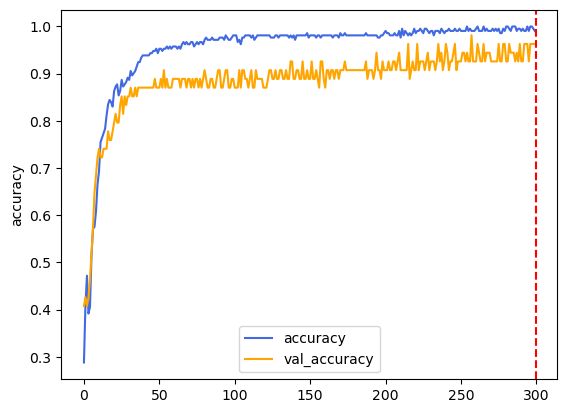

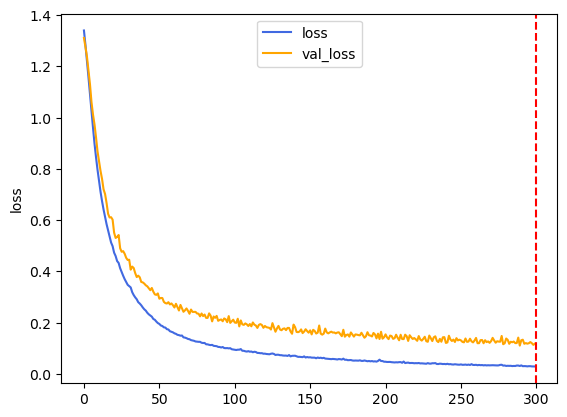

In [29]:
plot_acc(ff)
plt.show()
plot_loss(ff)
plt.show()

## PREDICTING ON BLIND TEST SET WITH ANN

The final ANN model presents an accuracy of 96.3%, with 

2023-05-01 15:50:29.681713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.963


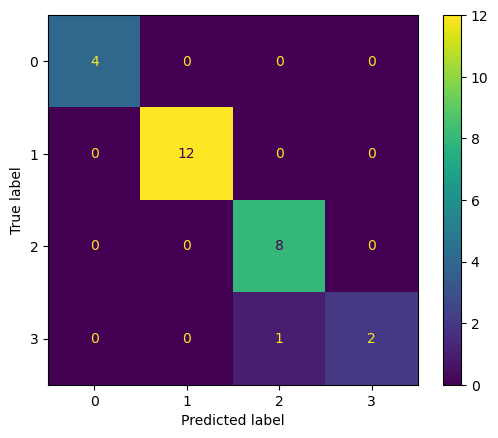

In [30]:
model_path = "./results/ANN_results/diff_seeds/58916/models/58916_21_model_epoch_-100_train_acc_0.91.h5"
final_model = keras.models.load_model(model_path)
final_preds = final_model.predict(x = X_blind, batch_size = 27, verbose = 0)
rounded_predictions = np.argmax(final_preds, axis = -1)
cm = confusion_matrix(y_true = y_blind, y_pred = rounded_predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()
blind_acc = sum(rounded_predictions == np.array(y_blind.label))/len(rounded_predictions)
print(round(blind_acc, 3))

In [31]:
p = blind_acc
p_se = 1.96*(math.sqrt(p*(1-p)/n))
print(round(p, 3))
print(round(p_se, 3))
print([round(p - p_se, 2), 1])

0.963
0.099
[0.86, 1]


In [32]:
ANN_pred_df = pd.DataFrame(np.around(final_preds,2))
ANN_pred_df["pred"] = rounded_predictions
ANN_pred_df["real"] = y_blind.label.tolist()
ANN_pred_df.index = y_blind_df.index

In [33]:
ANN_pred_df[ANN_pred_df.pred != ANN_pred_df.real]

,0,1,2,3,pred,real
Q32ZE1_0_BS3,0.0,0.0,0.73,0.27,2,3


In [34]:
ANN_pred_df[ANN_pred_df.pred != ANN_pred_df.real].index.tolist()

['Q32ZE1_0_BS3']

## PREDICTING ON BLIND TEST SET WITH KNN

In [35]:
knn = KNeighborsClassifier(n_neighbors=3)

In [36]:
knn.fit(X_model, y_model)

#Predict the response for test dataset
y_pred_KNN = knn.predict(X_blind)

acc_pred = metrics.accuracy_score(y_blind, y_pred_KNN)

/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.741


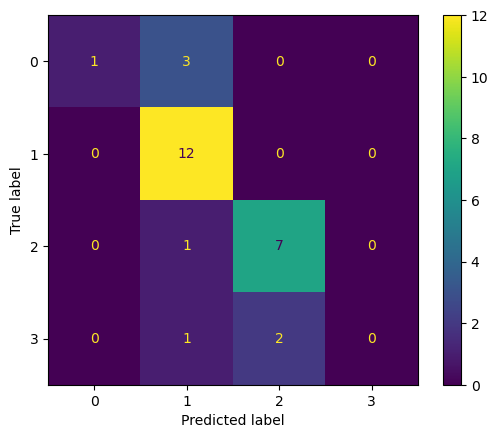

In [37]:
cm_KNN = confusion_matrix(y_true = y_blind, y_pred = y_pred_KNN)
cm_display_KNN = ConfusionMatrixDisplay(cm_KNN).plot()
blind_acc_KNN = sum(y_pred_KNN == y_blind.label)/len(y_pred_KNN)
print(round(blind_acc_KNN, 3))

In [38]:
p = blind_acc_KNN
p_se = 1.96*(math.sqrt(p*(1-p)/n))
print(round(p, 3))
print(round(p_se, 3))
print([round(p - p_se, 2), round(p + p_se, 2)])

0.741
0.23
[0.51, 0.97]


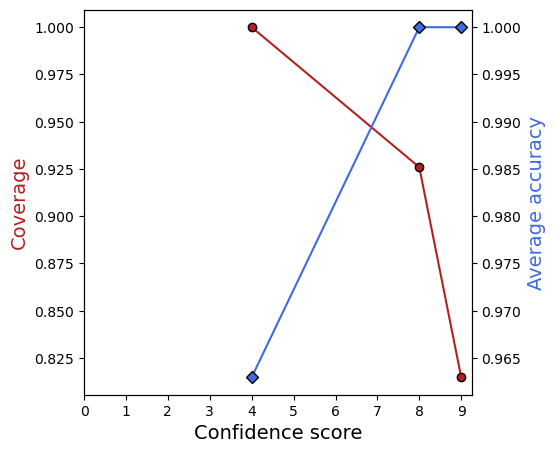

In [39]:
conf_good_df1, conf_good_df2 = get_confidences_df(final_preds, rounded_predictions, y_blind.label)

plot_conf_acc_cov(conf_good_df2)

In [40]:
conf_good_df1.head(3)

,conf,val,pred
0,9,1,1
1,9,1,1
2,9,1,1
